---
#### Train
---

In [1]:
import pandas as pd
import os
import numpy as np
import time
import pickle
import warnings
from datetime import datetime
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Conv1D, GlobalMaxPool1D, SimpleRNN
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

Using TensorFlow backend.


---
#### 일단 네이블 통해 받은 데이터로 훈련을 한다.
---

In [2]:
ct = pd.read_csv('training-data-Slice02-20200118.csv')

In [3]:
ct

,SLICE,DATETIME,UPLINK_THROUGHPUT,DNLINK_THROUGHPUT,ACTIVE_USER
0,Slice02,2020-01-18T00:00:00,13494992,192813301,2027
1,Slice02,2020-01-18T00:05:00,11850306,160630747,2071
2,Slice02,2020-01-18T00:10:00,12192035,147818101,2066
3,Slice02,2020-01-18T00:15:00,17341692,135313778,1900
4,Slice02,2020-01-18T00:20:00,11018423,107504493,1941
...,...,...,...,...,...
687,Slice02,2020-01-20T09:40:00,28929145,312426670,2880
688,Slice02,2020-01-20T09:45:00,32777799,371483537,2788
689,Slice02,2020-01-20T09:50:00,31873507,361038398,2904
690,Slice02,2020-01-20T09:55:00,31732812,334288274,3081


In [4]:
import numpy as np
def create_dataset(signal_data, look_back = 144):
    dataX, dataY = [], []
    for i in range(len(signal_data)-156):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[(i + look_back):(i+156), 0])
    return np.array(dataX), np.array(dataY)

look_back = 144 ## 하루. 

train = ct[['ACTIVE_USER']].values.reshape(-1,1)
x_train, y_train = create_dataset(train, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(SimpleRNN(144, return_sequences= True))
model.add(BatchNormalization())
model.add(SimpleRNN(144))
model.add(Dense(12, activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')
# mcp_save = ModelCheckpoint('/data01/CSB/CSB_Jupyter/PROBE/Pyfile/CSB-Modelling/10월16일/TANGO/best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

hist = model.fit(x_train/1e3, y_train/1e3, epochs=10, batch_size = 2)

Epoch 1/10
536/536 [==============================] - 40s 74ms/step - loss: 0.8832
Epoch 2/10
536/536 [==============================] - 39s 74ms/step - loss: 0.1718
Epoch 3/10
536/536 [==============================] - 38s 71ms/step - loss: 0.1883
Epoch 4/10
536/536 [==============================] - 37s 69ms/step - loss: 0.1862
Epoch 5/10
536/536 [==============================] - 37s 69ms/step - loss: 0.1858
Epoch 6/10
536/536 [==============================] - 37s 70ms/step - loss: 0.1760
Epoch 7/10
536/536 [==============================] - 37s 69ms/step - loss: 0.1690
Epoch 8/10
536/536 [==============================] - 37s 69ms/step - loss: 0.1636
Epoch 9/10
536/536 [==============================] - 37s 70ms/step - loss: 0.1597
Epoch 10/10
536/536 [==============================] - 37s 68ms/step - loss: 0.1665


#### model 저장

In [18]:
model.save('Slice02-prediction-active-user.h5')

#### 모델 제대로 돌아가는지 test 용

In [12]:
prediction = ct[['ACTIVE_USER']][0:144].values
    
    
result = model.predict(np.reshape(prediction,(1,144,1))/1e3)*1e3

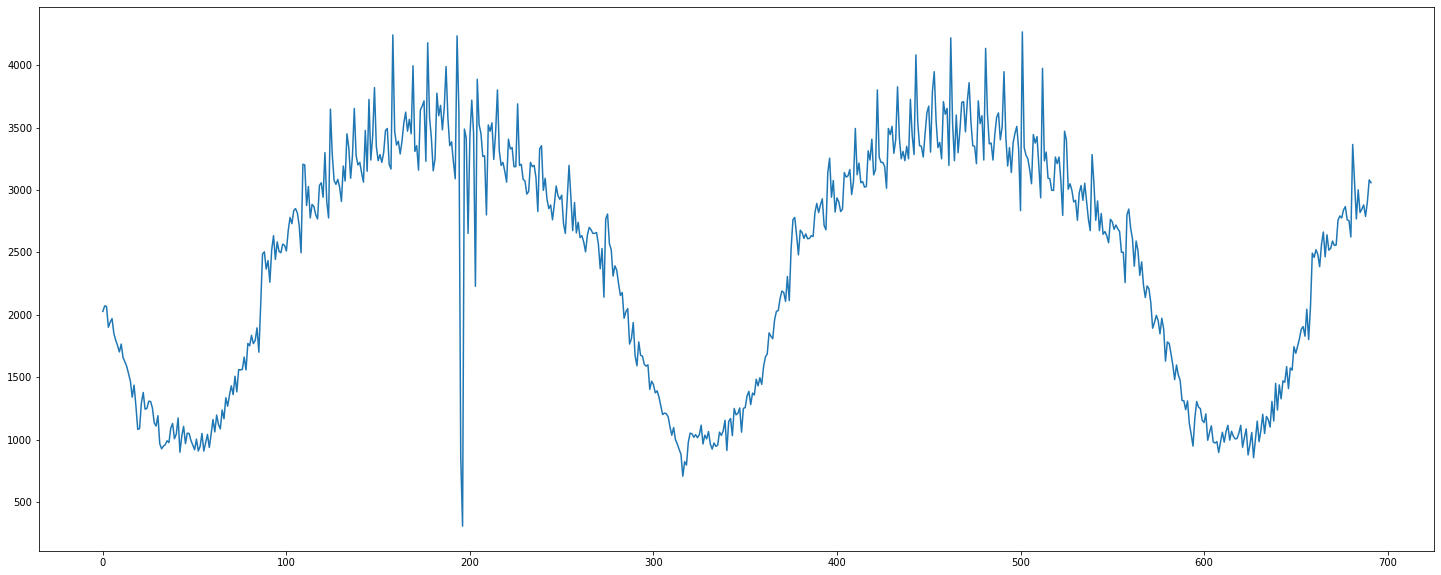

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.plot(ct[['ACTIVE_USER']])
plt.show()

In [14]:
ct[['ACTIVE_USER']]

,ACTIVE_USER
0,2027
1,2071
2,2066
3,1900
4,1941
...,...
687,2880
688,2788
689,2904
690,3081


In [15]:
test = pd.DataFrame(result[0])
test.columns =['ACTIVE_USER']

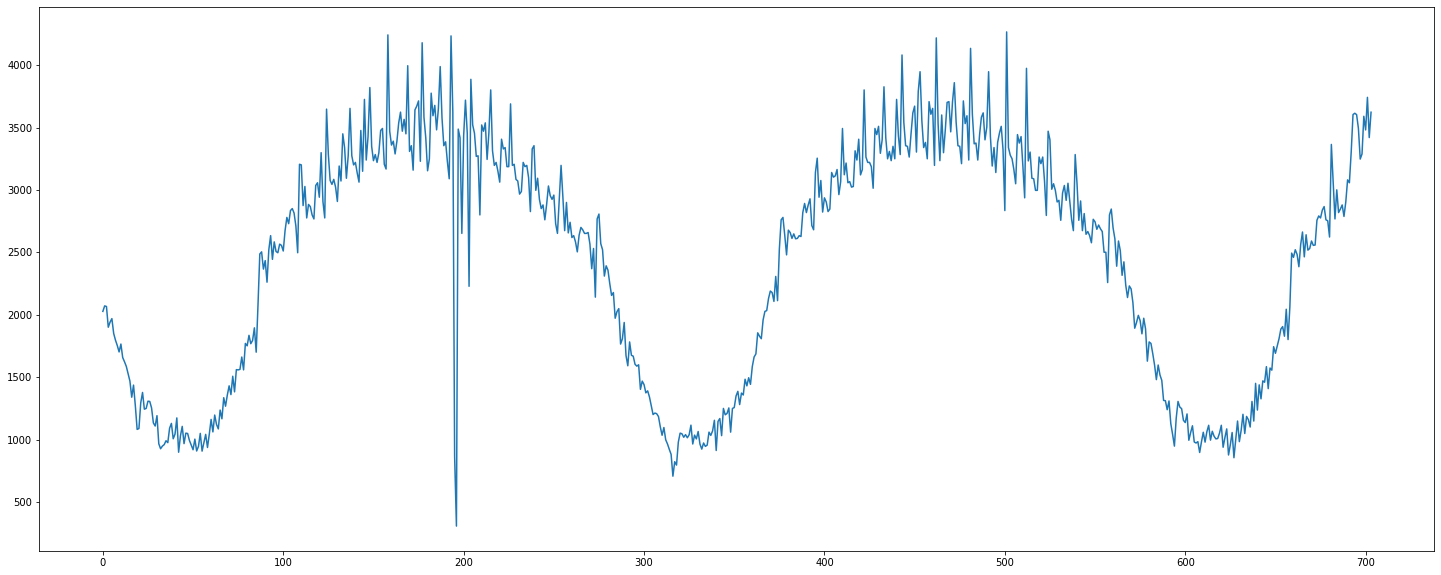

In [17]:
plt.figure(figsize=(25,10))
plt.plot(pd.concat([ct[['ACTIVE_USER']],test]).reset_index(drop=True))

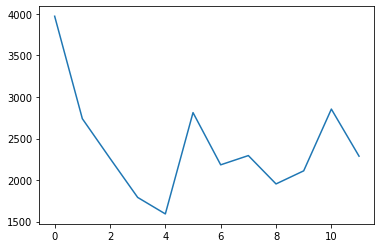

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(result[0])
